#**ResNet Training (CIFAR - 10)**

###**1. Import Library & Define Resnet model**

In [1]:
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import torchvision
import torchvision.transforms as transforms


class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        

conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels
    


class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
        
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )
        
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x
    
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x
    

class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x
    
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

###**2. Download CIFAR-10**

In [2]:
#Download CIFAR10 DATASET

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), 

    transforms.ToTensor(), normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(), normalize
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


###**3. CUDA setting & Define Train,Test function**

In [3]:
#gpu setting & define Training function

device = 'cuda'

net = resnet18(3,10)           #resnet18 선언
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.1
file_name = 'resnet18_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())

    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)
    total_accuracy = 100. * correct / total;

    return total_accuracy , train_loss


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)
    total_accuracy = 100. * correct / total;
    test_loss = loss / total

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    return total_accuracy , test_loss

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

###**4. Run Training & Save log**

In [4]:
# for epoch in range(0, 200):
log_train_total_accuracy =[]
log_train_total_loss = []
log_test_total_accuracy =[]
log_test_total_loss =[]


for epoch in range(0, 60):
    adjust_learning_rate(optimizer, epoch)
    train_total_accuracy, train_total_loss = train(epoch)
    test_total_accuracy, test_total_loss = test(epoch)
    log_train_total_accuracy.append(train_total_accuracy)
    log_train_total_loss.append(train_total_loss)
    log_test_total_accuracy.append(test_total_accuracy)
    log_test_total_loss.append(test_total_loss)


[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.1171875
Current benign train loss: 2.71610689163208

Current batch: 100
Current benign train accuracy: 0.1875
Current benign train loss: 2.238898992538452

Current batch: 200
Current benign train accuracy: 0.359375
Current benign train loss: 1.934208631515503

Current batch: 300
Current benign train accuracy: 0.28125
Current benign train loss: 1.749353051185608

Total benign train accuarcy: 24.828
Total benign train loss: 1000.6445177793503

[ Test epoch: 0 ]

Test accuarcy: 37.05
Test average loss: 0.01674027706384659
Model Saved!

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.375
Current benign train loss: 1.7616724967956543

Current batch: 100
Current benign train accuracy: 0.3203125
Current benign train loss: 1.7983301877975464

Current batch: 200
Current benign train accuracy: 0.4140625
Current benign train loss: 1.4650479555130005

Current batch: 300
Current benign train accuracy: 0.414

###**Additional Learning**

In [5]:
file_name = "/content/resnet18_cifar10.pt"
device = 'cuda'

net = resnet18(3,10)
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

file_name = 'resnet18_cifar10.pt'

# Reloading previous log
log_train_total_accuracy = [24.828, 39.022, 46.484, 51.814, 56.794, 60.446, 63.158, 64.658, 66.808, 68.268, 69.538, 70.566, 72.054, 72.718, 73.226, 74.336, 74.552, 75.096, 75.412, 76.044, 76.424, 76.768, 77.254, 77.58, 77.762, 77.93, 78.402, 78.732, 78.734, 79.312, 79.252, 79.66, 79.606, 79.79, 80.276, 80.228, 80.242, 80.638, 80.468, 80.602, 80.802, 80.866, 80.87, 81.204, 81.194, 81.298, 81.4, 81.222, 81.59, 81.594, 81.592, 81.432, 81.738, 82.022, 81.826, 81.872, 81.996, 82.014, 81.878, 82.298]
log_train_total_loss = [1000.6445177793503, 638.134519815445, 569.1794716119766, 517.9092298746109, 470.3034191131592, 434.5014297366142, 406.8080863952637, 392.2391785979271, 368.8352445960045, 351.9131098985672, 337.7790852189064, 329.61014807224274, 313.53922539949417, 306.34906965494156, 301.7087996006012, 289.85670787096024, 287.3095703125, 279.65443909168243, 277.21614146232605, 270.9929441511631, 263.9903101325035, 261.71662241220474, 257.6250042915344, 252.66414150595665, 251.5023691356182, 247.9092012345791, 242.34602484107018, 240.96856671571732, 238.5557440519333, 236.90085551142693, 234.48169699311256, 231.05524626374245, 231.73846340179443, 228.9497261941433, 224.2128805220127, 223.74473756551743, 222.78829872608185, 221.61214736104012, 222.97537177801132, 218.7889090180397, 217.78108072280884, 216.0823348760605, 217.10148257017136, 214.77994886040688, 213.67193308472633, 211.78261348605156, 210.40158677101135, 212.43221932649612, 207.0330407321453, 208.4358952641487, 208.11685928702354, 209.82582688331604, 205.08909782767296, 206.27790686488152, 205.61433270573616, 205.86896842718124, 203.92819052934647, 203.57387909293175, 205.0141015946865, 202.68405070900917]
log_test_total_accuracy =[37.05, 43.58, 48.81, 55.31, 60.1, 59.03, 63.89, 66.22, 65.17, 70.95, 70.73, 70.71, 71.54, 72.22, 70.99, 71.41, 73.37, 75.24, 73.26, 75.28, 75.98, 75.96, 76.36, 76.13, 75.88, 78.2, 77.1, 77.81, 78.05, 78.7, 78.45, 77.72, 79.07, 78.51, 79.02, 75.53, 78.54, 78.77, 78.36, 78.85, 78.78, 79.3, 79.24, 80.3, 80.03, 79.97, 78.5, 78.86, 79.52, 78.81, 78.88, 79.34, 79.77, 80.1, 80.24, 78.88, 79.84, 80.05, 79.19, 79.62]
log_test_total_loss = [0.01674027706384659, 0.015004920613765717, 0.01438833725452423, 0.012664032393693923, 0.011335756605863572, 0.012089525562524796, 0.010165771597623824, 0.009764814853668213, 0.010256566333770752, 0.008336396837234496, 0.00850631143450737, 0.008790287631750106, 0.008589729964733124, 0.007976709359884262, 0.008450704485177993, 0.00847343893647194, 0.007792597669363022, 0.007287565937638283, 0.007824639821052552, 0.007346135845780373, 0.0069530325710773465, 0.007259139889478684, 0.006876612371206283, 0.007027878677845001, 0.007164498019218445, 0.006393658694624901, 0.006707648265361786, 0.006427547609806061, 0.00632707066833973, 0.006360523292422295, 0.006321187144517898, 0.006589432212710381, 0.0062515938103199, 0.006299051240086556, 0.006180387899279594, 0.007231214421987533, 0.0064889052659273146, 0.00624834354519844, 0.006520302832126617, 0.006451968562602997, 0.006270318141579628, 0.00641234110891819, 0.006230170378088951, 0.00602025714814663, 0.005901772505044937, 0.0058443341732025145, 0.006296010360121727, 0.0063572420448064805, 0.006206543880701065, 0.006176814192533493, 0.006305304837226868, 0.006224010801315308, 0.005917224699258804, 0.00585750789642334, 0.005838066563010216, 0.00620809238255024, 0.006084652084112167, 0.006057832154631615, 0.006064933639764786, 0.0060181604981422426]

for epoch in range(0, 40):
    adjust_learning_rate(optimizer, epoch)
    train_total_accuracy, train_total_loss = train(epoch)
    test_total_accuracy, test_total_loss = test(epoch)
    log_train_total_accuracy.append(train_total_accuracy)
    log_train_total_loss.append(train_total_loss)
    log_test_total_accuracy.append(test_total_accuracy)
    log_test_total_loss.append(test_total_loss)


[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.859375
Current benign train loss: 0.45444393157958984

Current batch: 100
Current benign train accuracy: 0.7890625
Current benign train loss: 0.6122598052024841

Current batch: 200
Current benign train accuracy: 0.8125
Current benign train loss: 0.42537373304367065

Current batch: 300
Current benign train accuracy: 0.8359375
Current benign train loss: 0.4248219132423401

Total benign train accuarcy: 83.406
Total benign train loss: 189.4816066622734

[ Test epoch: 0 ]

Test accuarcy: 81.42
Test average loss: 0.005434942990541458
Model Saved!

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.8125
Current benign train loss: 0.47953000664711

Current batch: 100
Current benign train accuracy: 0.859375
Current benign train loss: 0.3686324656009674

Current batch: 200
Current benign train accuracy: 0.84375
Current benign train loss: 0.3964373767375946

Current batch: 300
Current benign train accuracy: 

###**5. Plotting Train Accuracy & Loss**

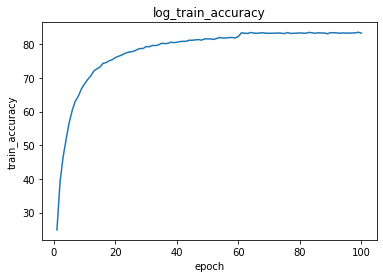

In [6]:
epoch =[]

for i , loss in enumerate(log_test_total_loss):
  epoch.append(i+1)

import matplotlib.pyplot as plt

plt.title('log_train_accuracy')
plt.plot(epoch , log_train_total_accuracy)
plt.xlabel('epoch')
plt.ylabel('train_accuracy')
plt.show()  

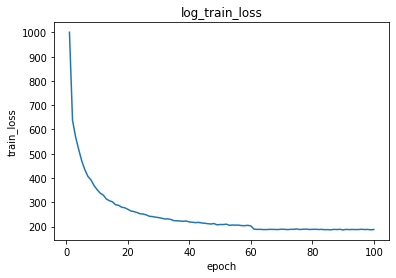

In [7]:
import matplotlib.pyplot as plt

plt.title('log_train_loss')
plt.plot(epoch , log_train_total_loss)
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.show()

###**6. Plotting Test Accuracy & Loss**

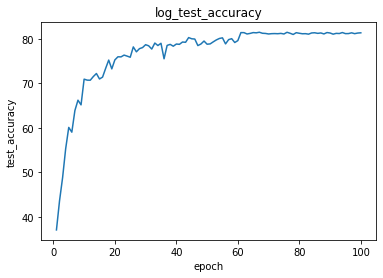

In [8]:
import matplotlib.pyplot as plt

plt.title('log_test_accuracy')
plt.plot(epoch , log_test_total_accuracy)
plt.xlabel('epoch')
plt.ylabel('test_accuracy')
plt.show()

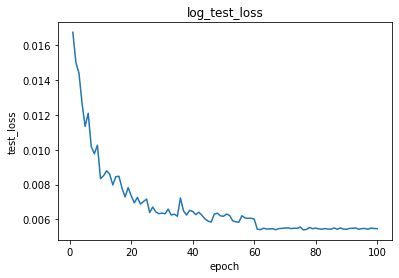

In [9]:
import matplotlib.pyplot as plt

plt.title('log_test_loss')
plt.plot(epoch , log_test_total_loss)
plt.xlabel('epoch')
plt.ylabel('test_loss')
plt.show()

###**7. Print Result**

In [10]:
print(log_train_total_accuracy)
print(log_train_total_loss) 
print(log_test_total_accuracy)
print(log_test_total_loss)

[24.828, 39.022, 46.484, 51.814, 56.794, 60.446, 63.158, 64.658, 66.808, 68.268, 69.538, 70.566, 72.054, 72.718, 73.226, 74.336, 74.552, 75.096, 75.412, 76.044, 76.424, 76.768, 77.254, 77.58, 77.762, 77.93, 78.402, 78.732, 78.734, 79.312, 79.252, 79.66, 79.606, 79.79, 80.276, 80.228, 80.242, 80.638, 80.468, 80.602, 80.802, 80.866, 80.87, 81.204, 81.194, 81.298, 81.4, 81.222, 81.59, 81.594, 81.592, 81.432, 81.738, 82.022, 81.826, 81.872, 81.996, 82.014, 81.878, 82.298, 83.406, 83.286, 83.22, 83.498, 83.34, 83.252, 83.364, 83.408, 83.276, 83.276, 83.278, 83.29, 83.354, 83.284, 83.178, 83.468, 83.226, 83.266, 83.318, 83.37, 83.298, 83.28, 83.524, 83.404, 83.272, 83.41, 83.354, 83.34, 83.126, 83.468, 83.418, 83.396, 83.276, 83.38, 83.304, 83.322, 83.35, 83.388, 83.574, 83.316]
[1000.6445177793503, 638.134519815445, 569.1794716119766, 517.9092298746109, 470.3034191131592, 434.5014297366142, 406.8080863952637, 392.2391785979271, 368.8352445960045, 351.9131098985672, 337.7790852189064, 329.61

###**8. Model Summary**

In [11]:
from torchsummary import summary

model = resnet18(3, 10)
summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
        Conv2dAuto-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
        Conv2dAuto-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
 ResNetBasicBlock-10             [-1, 64, 8, 8]               0
       Conv2dAuto-11             [-1, 64, 8, 8]          36,864
      BatchNorm2d-12             [-1, 64, 8, 8]             128
             ReLU-13             [-1, 64, 8, 8]               0
       Conv2dAuto-14             [-1, 6